# Data processing NDVI

In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import rasterio
import os
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import time
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
from rasterio.transform import from_origin
from rasterio.plot import show
from shapely.geometry import box, Point, Polygon
from osgeo import gdal
from geopandas import GeoSeries
from geopandas.tools import sjoin
from numpy.random import RandomState
from skimage.filters.rank import modal
from skimage.util import img_as_ubyte
from PIL import Image as im

%matplotlib inline

In [2]:
#!pip install scikit-learn
#!pip install -U scikit-image

# 1. Normalized difference vegetation index (NDVI)

## 1.1. Step 1: processing NDVI input image

In [3]:
# data dir
data_dir = r"thesis_project/data"
fp = os.path.join(data_dir, "CR_NDVI_2.TIF")

# open the file
ndvi_input_raster = rasterio.open(fp)

# check type of the variable 'raster'
type(ndvi_input_raster)

rasterio.io.DatasetReader

In [4]:
# check metadata for the whole raster dataset
ndvi_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

In [5]:
# check boundaries raster
ndvi_input_raster.bounds

BoundingBox(left=341660.6724, bottom=371164.6389, right=416090.6724, top=431034.6389)

In [6]:
# read the raster band as separate variable
ndvi_input = ndvi_input_raster.read(1)
type(ndvi_input)

numpy.ndarray

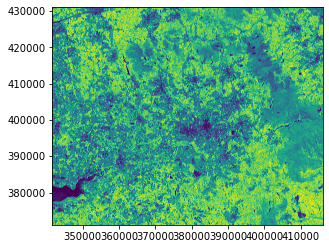

<AxesSubplot:>

In [7]:
# plot input NDVI
show(ndvi_input_raster, 1)

## 1.2. Step 2: focal statistics analysis

### 1.2.1. Focal statistics analysis for a buffer zone of 100 meters

In [8]:
# design kernel for a buffer zone of 100 m (r = 21 for 10 x 10 m resolution)
ndvi_filter_100 = np.ones((21, 21))
ndvi_filter_100.shape

(21, 21)

In [9]:
# convolve filter (i.e. buffer zone) over the whole NDVI image using FFT and average NDVI values. 
# if mode = "same", the output size will equal the size of the input. Convolution assumes zero-padding boundaries.
start_time = time.time()
ndvi_output_100 = fftconvolve(ndvi_input, ndvi_filter_100, mode = "same") / np.sum(ndvi_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_100.shape

--- 2.792036771774292 seconds ---


(5987, 7443)

### 1.2.2. Focal statistics analysis for a buffer zone of 300 meters

In [10]:
# design kernel for a buffer zone of 300 m (r = 61 for 10 x 10 m resolution)
ndvi_filter_300 = np.ones((61, 61))
ndvi_filter_300.shape

(61, 61)

In [11]:
# convolve filter (i.e. buffer zone) over the whole NDVI image using FFT and average NDVI values 
start_time = time.time()
ndvi_output_300 = fftconvolve(ndvi_input, ndvi_filter_300, mode = "same") / np.sum(ndvi_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_300.shape

--- 2.779823064804077 seconds ---


(5987, 7443)

### 1.2.3. Focal statistics analysis for a buffer zone of 500 meters

In [12]:
# design kernel for a buffer zone of 500 m (r = 101 for 10 x 10 m resolution)
ndvi_filter_500 = np.ones((101, 101))
ndvi_filter_500.shape

(101, 101)

In [13]:
# convolve filter (i.e. buffer zone) over the whole NDVI image using FFT and average NDVI values
start_time = time.time()
ndvi_output_500 = fftconvolve(ndvi_input, ndvi_filter_500, mode = "same") / np.sum(ndvi_filter_500) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_500.shape

--- 2.805873155593872 seconds ---


(5987, 7443)

## 1.3. Step 3: development of NDVI exposure maps

### 1.3.1. NDVI map capturing exposure for a buffer zone of 100 m

In [14]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/ndvi_output_100_2.tif', 'w', driver='GTiff',
                            height = ndvi_output_100.shape[0], width = ndvi_output_100.shape[1],
                            count=1, dtype=str(ndvi_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_100, 1)
new_dataset.close()

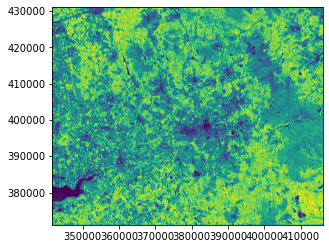

--- 2.0980958938598633 seconds ---


In [15]:
# NDVI exposure map at 100 m
start_time = time.time()
ndvi_src_100 = rasterio.open("thesis_project/output/layers/ndvi_output_100_2.tif")
show(ndvi_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
# output layer metadata
ndvi_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.2. NDVI map capturing exposure for a buffer zone of 300 m

In [17]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/ndvi_output_300_2.tif', 'w', driver='GTiff',
                            height = ndvi_output_300.shape[0], width = ndvi_output_300.shape[1],
                            count=1, dtype=str(ndvi_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_300, 1)
new_dataset.close()

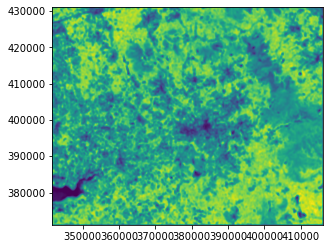

--- 2.0985019207000732 seconds ---


In [18]:
# NDVI exposure map at 300 m
start_time = time.time()
ndvi_src_300 = rasterio.open("thesis_project/output/layers/ndvi_output_300_2.tif")
show(ndvi_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
# check meta
ndvi_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.3. NDVI map capturing exposure for a buffer zone of 500 m

In [20]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/ndvi_output_500_2.tif', 'w', driver='GTiff',
                            height = ndvi_output_500.shape[0], width = ndvi_output_500.shape[1],
                            count=1, dtype=str(ndvi_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_500, 1)
new_dataset.close()

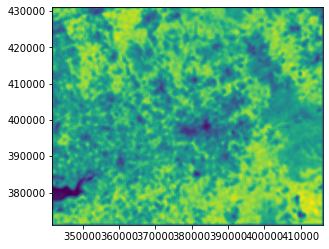

--- 2.3677279949188232 seconds ---


In [21]:
# NDVI exposure map at 500 m
start_time = time.time()
ndvi_src_500 = rasterio.open("thesis_project/output/layers/ndvi_output_500_2.tif")
show(ndvi_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [22]:
# check crs
ndvi_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

## 1.4. Step 4: random location sampling within the Greater Manchester area

In [23]:
# check Greater Manchester area boundaries
gm_boundaries = gpd.read_file("thesis_project/data/GM_Boundary.gpkg")
gm_boundaries.bounds

,minx,miny,maxx,maxy
0,351662.603729,381165.401794,406087.19669,421037.698468


### 1.4.1. Random location sampling within the study area for a buffer zone of 100 m

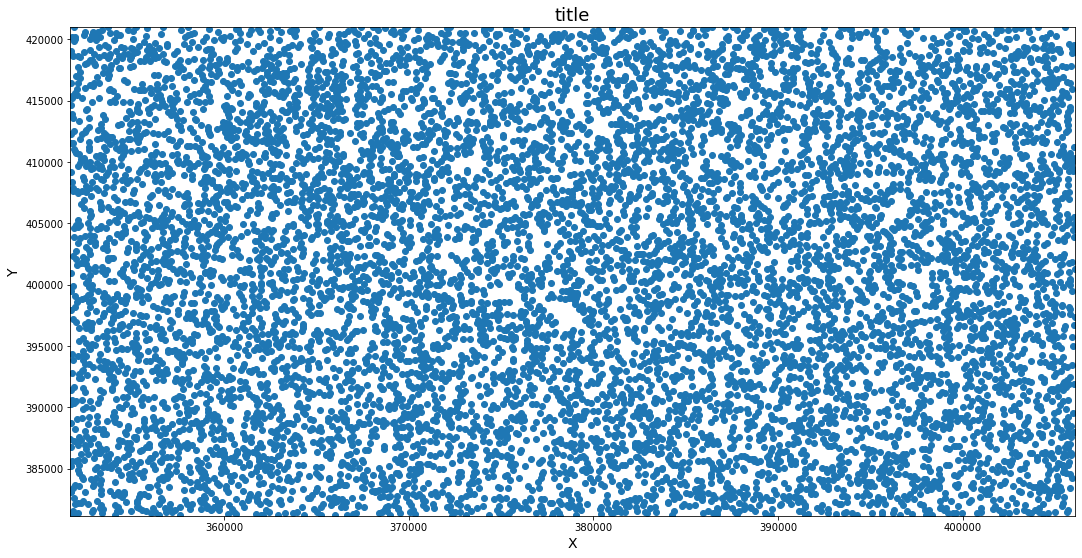

In [24]:
# generate random points (i.e. locations) 100 meters apart from each other using Euclidean distance
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

#prng = RandomState(1234567890)

points_100 = np.array([])       # x, y columnwise
while points_100.shape[0] < 10000:
    np.random.seed(42)
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_100) == 0:                # add first point blindly
        points_100 = np.array([p])
    elif distance(p, points_100, 100):     # ensure the minimum distance equal to buffer zone is met
        points_100 = np.vstack((points_100, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_100[:,0], points_100[:,1])

In [25]:
# convert np array to point geometry
x, y = np.split(points_100,[-1],axis=1) # split array into x and y
sample_100 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_100 = pd.DataFrame(sample_100, columns=['geometry'])
gdf_100 = gpd.GeoDataFrame(df_100, geometry='geometry', crs = 'epsg:27700')
gdf_100.head()                      


,geometry
0,POINT (386483.262 417703.544)
1,POINT (395310.475 388609.235)
2,POINT (384225.708 417867.819)
3,POINT (390673.998 416261.747)
4,POINT (393523.154 393041.484)


In [26]:
# save gpd to GeoJSON
gdf_100.to_file("thesis_project/output/points/sample_points_100.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 1.4.2. Random location sampling within the study area for a buffer zone of 300 m

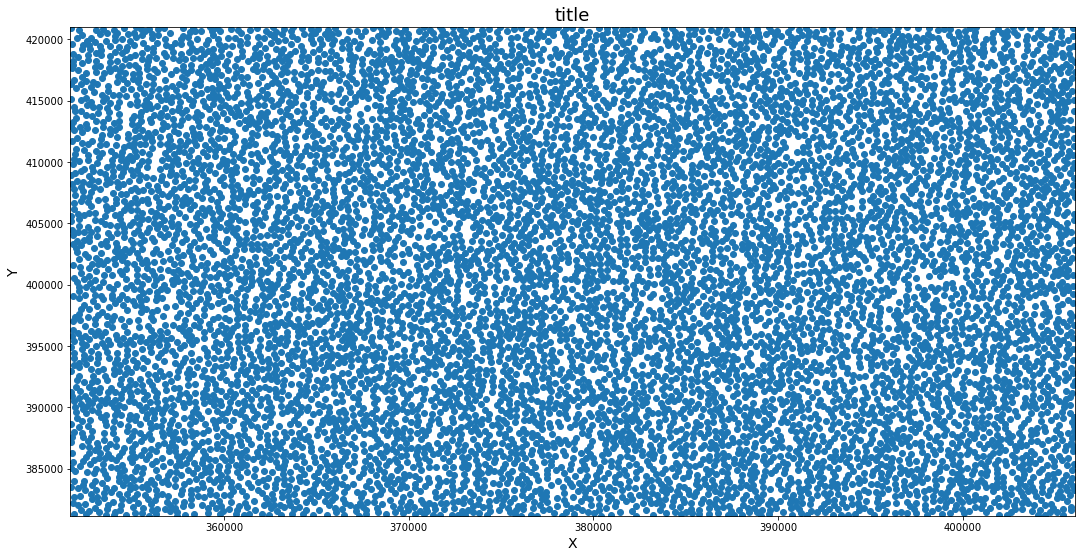

In [27]:
# generate random points (i.e. locations) 300 meters apart from each other using Euclidean distance
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_300 = np.array([])       # x, y columnwise
while points_300.shape[0] < 10000:
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_300) == 0:                # add first point blindly
        points_300 = np.array([p])
    elif distance(p, points_300, 300):     # ensure the minimum distance is met
        points_300 = np.vstack((points_300, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_300[:,0], points_300[:,1])

In [28]:
# convert np array to point geometry
x, y = np.split(points_300,[-1],axis=1) # split array into x and y
sample_300 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_300 = pd.DataFrame(sample_300, columns=['geometry'])
gdf_300 = gpd.GeoDataFrame(df_300, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_300.to_file("thesis_project/output/points/sample_points_300.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 1.4.3. Random location sampling within the study area for a buffer zone of 500 m

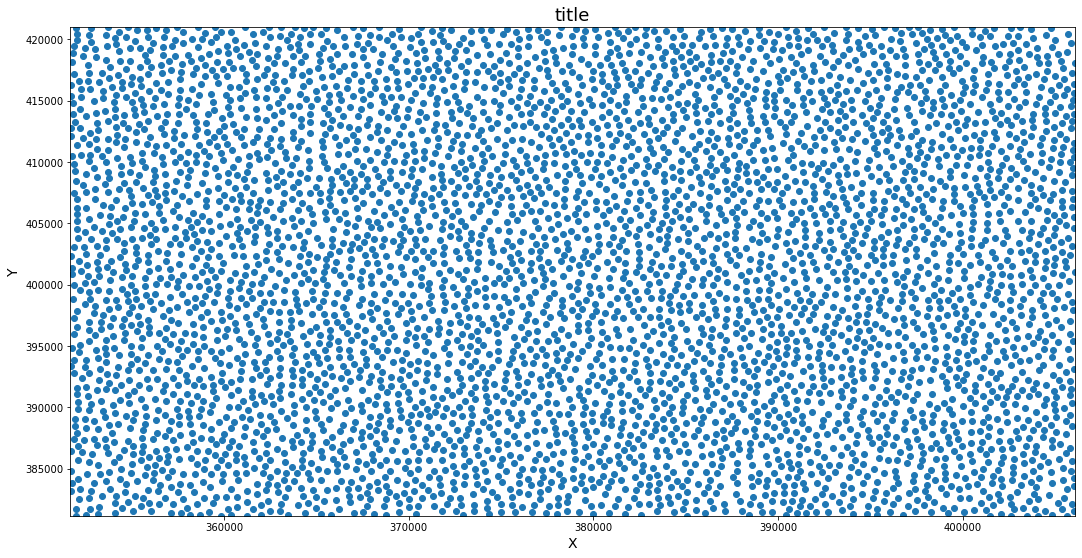

In [29]:
# generate random points (i.e. locations) 500 meters apart from each other using Euclidean distance
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_500 = np.array([])       # x, y columnwise
while points_500.shape[0] < 5000:
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_500) == 0:                # add first point blindly
        points_500 = np.array([p])
    elif distance(p, points_500, 500):     # ensure the minimum distance is met
        points_500 = np.vstack((points_500, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_500[:,0], points_500[:,1])

In [30]:
# convert np array to point geometry
x, y = np.split(points_500,[-1],axis=1) # split array into x and y
points_500 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_500 = pd.DataFrame(points_500, columns=['geometry'])
gdf_500 = gpd.GeoDataFrame(df_500, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_500.to_file("thesis_project/output/points/sample_points_500.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# 1.5. Step 5: extraction of raster values

### 1.5.1. Extraction of NDVI values for a buffer zone of 100 m

In [31]:
# check point locations df
gdf_100.head()

,geometry
0,POINT (386483.262 417703.544)
1,POINT (395310.475 388609.235)
2,POINT (384225.708 417867.819)
3,POINT (390673.998 416261.747)
4,POINT (393523.154 393041.484)


In [32]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_100.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_100['point_coordinates'] = point_coords
gdf_100.head()

,geometry,point_coordinates
0,POINT (386483.262 417703.544),"(386483.2622661036, 417703.5436785722)"
1,POINT (395310.475 388609.235),"(395310.47527057823, 388609.2352984041)"
2,POINT (384225.708 417867.819),"(384225.7075745344, 417867.8191836241)"
3,POINT (390673.998 416261.747),"(390673.99783145625, 416261.7470128737)"
4,POINT (393523.154 393041.484),"(393523.1537645239, 393041.4841191741)"


In [33]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['NDVI_100'] = [x[0] for x in ndvi_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100
0,POINT (386483.262 417703.544),"(386483.2622661036, 417703.5436785722)",0.455823
1,POINT (395310.475 388609.235),"(395310.47527057823, 388609.2352984041)",0.387782
2,POINT (384225.708 417867.819),"(384225.7075745344, 417867.8191836241)",0.389722
3,POINT (390673.998 416261.747),"(390673.99783145625, 416261.7470128737)",0.623486
4,POINT (393523.154 393041.484),"(393523.1537645239, 393041.4841191741)",0.628733


### 1.5.2. Extraction of NDVI values for a buffer zone of 300 m

In [34]:
# check point locations df
gdf_300.head()

,geometry
0,POINT (387760.076 393972.512)
1,POINT (361558.182 408801.964)
2,POINT (373792.953 382499.542)
3,POINT (391126.815 417220.287)
4,POINT (361327.964 411390.899)


In [35]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_300.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_300['point_coordinates'] = point_coords
gdf_300.head()

,geometry,point_coordinates
0,POINT (387760.076 393972.512),"(387760.0759851058, 393972.5115567864)"
1,POINT (361558.182 408801.964),"(361558.18217695353, 408801.96443030925)"
2,POINT (373792.953 382499.542),"(373792.9530222948, 382499.54218211595)"
3,POINT (391126.815 417220.287),"(391126.8149730632, 417220.28661031264)"
4,POINT (361327.964 411390.899),"(361327.9638465452, 411390.8985426932)"


In [36]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['NDVI_300'] = [x[0] for x in ndvi_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300
0,POINT (387760.076 393972.512),"(387760.0759851058, 393972.5115567864)",0.280478
1,POINT (361558.182 408801.964),"(361558.18217695353, 408801.96443030925)",0.503846
2,POINT (373792.953 382499.542),"(373792.9530222948, 382499.54218211595)",0.534135
3,POINT (391126.815 417220.287),"(391126.8149730632, 417220.28661031264)",0.589265
4,POINT (361327.964 411390.899),"(361327.9638465452, 411390.8985426932)",0.493672


### 1.5.3. Extraction of NDVI values for a buffer zone of 500 m

In [37]:
# check point locations df
gdf_500.head()

,geometry
0,POINT (401901.359 408671.581)
1,POINT (360687.924 381854.801)
2,POINT (370492.613 385685.371)
3,POINT (402055.383 382460.467)
4,POINT (368835.367 407479.786)


In [38]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_500.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_500['point_coordinates'] = point_coords
gdf_500.head()

,geometry,point_coordinates
0,POINT (401901.359 408671.581),"(401901.3593869965, 408671.58071634814)"
1,POINT (360687.924 381854.801),"(360687.9242329277, 381854.8006974825)"
2,POINT (370492.613 385685.371),"(370492.6127017365, 385685.37054465216)"
3,POINT (402055.383 382460.467),"(402055.3825253075, 382460.466940623)"
4,POINT (368835.367 407479.786),"(368835.3672736198, 407479.7858508136)"


In [39]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['NDVI_500'] = [x[0] for x in ndvi_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500
0,POINT (401901.359 408671.581),"(401901.3593869965, 408671.58071634814)",0.407077
1,POINT (360687.924 381854.801),"(360687.9242329277, 381854.8006974825)",0.583116
2,POINT (370492.613 385685.371),"(370492.6127017365, 385685.37054465216)",0.483239
3,POINT (402055.383 382460.467),"(402055.3825253075, 382460.466940623)",0.638895
4,POINT (368835.367 407479.786),"(368835.3672736198, 407479.7858508136)",0.441260


# 2. All green spaces

## 2.1. Step 1: processing green spaces input image

In [40]:
# data dir
data_dir = r"thesis_project/data"
fp_green = os.path.join(data_dir, "GreenNoGreenRes.TIF")

# open the file
green_input_raster = rasterio.open(fp_green)

# check type of the variable 'raster'
type(green_input_raster)

rasterio.io.DatasetReader

In [41]:
# check metadata for the whole raster dataset
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

In [42]:
# read the raster band as separate variable
green_input = green_input_raster.read(1)
#type(green_input)
green_input

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

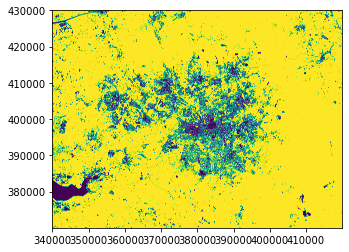

<AxesSubplot:>

In [43]:
# plot Greenspace input
show(green_input_raster, 1)

## 2.2. Step 2: focal statistics analysis

### 2.2.1.Focal statistics analysis for a buffer zone of 100 meters

In [44]:
# design kernel for a buffer zone of 100 m (r = 41 for 5 x 5 m resolution)
green_filter_100 = np.ones((41, 41))
green_filter_100.shape

(41, 41)

In [45]:
# convolve filter (i.e. buffer zone) over the whole Greenspace image using FFT and average NDVI values. 
# if mode = "same", the output size will equal the size of the input. Convolution assumes zero-padding boundaries.
start_time = time.time()
green_output_100 = fftconvolve(green_input, green_filter_100, mode = "same") / np.sum(green_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_100.shape

--- 24.028023958206177 seconds ---


(12000, 16000)

### 2.2.2. Focal statistics analysis for a buffer zone of 300 meters

In [46]:
# design kernel for a buffer zone of 300 m (r = 121 for 5 x 5 m resolution)
green_filter_300 = np.ones((121, 121))
green_filter_300.shape

(121, 121)

In [47]:
# convolve filter (i.e. buffer zone) over the whole Greenspace image using FFT and average NDVI values. 
start_time = time.time()
green_output_300 = fftconvolve(green_input, green_filter_300, mode = "same") / np.sum(green_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_300.shape

--- 21.843477964401245 seconds ---


(12000, 16000)

### 2.2.3. Focal statistics analysis for a buffer zone of 500 meters

In [48]:
# design kernel for a buffer zone of 500 m (r = 201 for 5 x 5 m resolution)
green_filter_500 = np.ones((201, 201))
green_filter_500.shape

(201, 201)

In [49]:
# convolve filter (i.e. buffer zone) over the whole Greenspace image using FFT and average NDVI values.
start_time = time.time()
green_output_500 = fftconvolve(green_input, green_filter_500, mode = "same") / np.sum(green_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_500.shape

--- 22.28351593017578 seconds ---


(12000, 16000)

## 2.3. Step 3: development of Greenspace% exposure maps

In [50]:
# Greenspace input image boundaries
green_input_raster.bounds

BoundingBox(left=339999.2458, bottom=370003.9122, right=419999.2458, top=430003.9122)

In [51]:
# check raster metadata
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.1. Greenspace% map capturing exposure for a buffer zone of 100 m

In [52]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/green_output_100.tif', 'w', driver='GTiff',
                            height = green_output_100.shape[0], width = green_output_100.shape[1],
                            count=1, dtype=str(green_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_100, 1)
new_dataset.close()

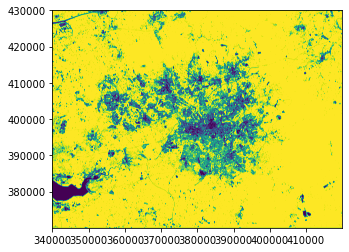

--- 12.204488039016724 seconds ---


In [53]:
# Greenspace% exposure map at 100 m
start_time = time.time()
green_src_100 = rasterio.open("thesis_project/output/layers/green_output_100.tif")
show(green_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [54]:
# output layer metadata
green_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.2. Greenspace% map capturing exposure for a buffer zone of 300 m

In [55]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/green_output_300.tif', 'w', driver='GTiff',
                            height = green_output_300.shape[0], width = green_output_300.shape[1],
                            count=1, dtype=str(green_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_300, 1)
new_dataset.close()

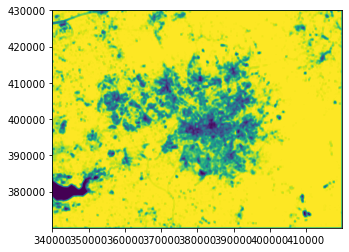

--- 20.257760047912598 seconds ---


In [56]:
# Greenspace% exposure map 300 m
start_time = time.time()
green_src_300 = rasterio.open("thesis_project/output/layers/green_output_300.tif")
show(green_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [57]:
# output layer metadata
green_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.3. Greenspace% map capturing exposure for a buffer zone of 500 m

In [58]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/green_output_500.tif', 'w', driver='GTiff',
                            height = green_output_500.shape[0], width = green_output_500.shape[1],
                            count=1, dtype=str(green_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_500, 1)
new_dataset.close()

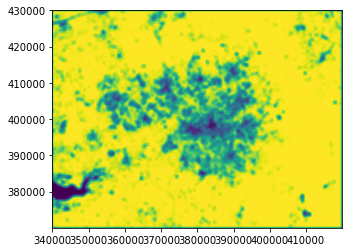

--- 15.344213962554932 seconds ---


In [59]:
# Greenspace% exposure map at 500 m
start_time = time.time()
green_src_500 = rasterio.open("thesis_project/output/layers/green_output_500.tif")
show(green_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [60]:
# output layer metadata
green_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### Step 4: random location sampling within the Greater Manchester area is no longer required as the data frame used only contains locations that satisfy step 4.

## 2.4. Step 5: extraction of raster values

### 2.4.1. Extraction of Greenspace% values for a buffer zone of 100 m

In [61]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Greenspace%_100'] = [x[0] for x in green_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (386483.262 417703.544),"(386483.2622661036, 417703.5436785722)",0.455823,0.992861
1,POINT (395310.475 388609.235),"(395310.47527057823, 388609.2352984041)",0.387782,0.521713
2,POINT (384225.708 417867.819),"(384225.7075745344, 417867.8191836241)",0.389722,0.979774
3,POINT (390673.998 416261.747),"(390673.99783145625, 416261.7470128737)",0.623486,0.771565
4,POINT (393523.154 393041.484),"(393523.1537645239, 393041.4841191741)",0.628733,0.886972


In [62]:
# check if null values in gdf
gdf_100.isnull().values.any()

False

### 2.4.2. Extraction of Greenspace% values for a buffer zone of 300 m

In [63]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Greenspace%_300'] = [x[0] for x in green_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (387760.076 393972.512),"(387760.0759851058, 393972.5115567864)",0.280478,0.326412
1,POINT (361558.182 408801.964),"(361558.18217695353, 408801.96443030925)",0.503846,0.847073
2,POINT (373792.953 382499.542),"(373792.9530222948, 382499.54218211595)",0.534135,0.999454
3,POINT (391126.815 417220.287),"(391126.8149730632, 417220.28661031264)",0.589265,0.831569
4,POINT (361327.964 411390.899),"(361327.9638465452, 411390.8985426932)",0.493672,0.796394


In [64]:
# check if null values in gdf
gdf_300.isnull().values.any()

False

### 2.4.3. Extraction of Greenspace% values for a buffer zone of 500 m

In [65]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Greenspace%_500'] = [x[0] for x in green_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (401901.359 408671.581),"(401901.3593869965, 408671.58071634814)",0.407077,0.982575
1,POINT (360687.924 381854.801),"(360687.9242329277, 381854.8006974825)",0.583116,0.985842
2,POINT (370492.613 385685.371),"(370492.6127017365, 385685.37054465216)",0.483239,0.994406
3,POINT (402055.383 382460.467),"(402055.3825253075, 382460.466940623)",0.638895,0.997822
4,POINT (368835.367 407479.786),"(368835.3672736198, 407479.7858508136)",0.441260,0.575357


In [66]:
# check if null values in gdf
gdf_500.isnull().values.any()

False

# 3. Tree canopy

## 3.1. Step 1: processing Tree canopy input image

In [67]:
# data dir
data_dir = r"thesis_project/data"
fp_tree = os.path.join(data_dir, "Tree_no_Tree_10m.TIF")

# open the file
tree_input_raster = rasterio.open(fp_tree)

# check type of the variable 'raster'
type(tree_input_raster)

rasterio.io.DatasetReader

In [68]:
# check metadata for the whole raster dataset
tree_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

In [69]:
# read the raster band as separate variable
tree_input = tree_input_raster.read(1)
#tree_input
type(tree_input)


numpy.ndarray

In [70]:
# convert array to uint8
tree_input = tree_input.astype(np.uint8)
tree_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

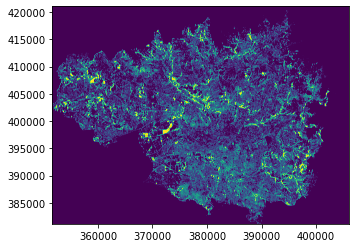

<AxesSubplot:>

In [71]:
# plot Tree canopy input image
show(tree_input_raster, 1)

## 3.2. Step 2: focal statistics analysis

### 3.2.1. Focal statistics analysis for a buffer zone of 100 meters

In [72]:
# design kernel for a buffer zone of 100 m (r = 21 for 10 x 10 m resolution)
canopy_filter_100 = np.ones((21, 21))
canopy_filter_100.shape

(21, 21)

In [73]:
# convolve filter (i.e. buffer zone) over the whole Tree canopy image using FFT and average NDVI values. 
# if mode = "same", the output size will equal the size of the input. Convolution assumes zero-padding boundaries.
start_time = time.time()
canopy_output_100 = fftconvolve(tree_input, canopy_filter_100, mode = "same") / np.sum(canopy_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
canopy_output_100.shape

--- 1.6351358890533447 seconds ---


(3987, 5441)

### 3.2.2. Focal statistics analysis for a buffer zone of 300 meters

In [74]:
# design kernel for a buffer zone of 300 m (r = 61 for 10 x 10 m resolution)
canopy_filter_300 = np.ones((61, 61))
canopy_filter_300.shape

(61, 61)

In [75]:
# convolve filter (i.e. buffer zone) over the whole Tree canopy image using FFT and average NDVI values.
start_time = time.time()
canopy_output_300 = fftconvolve(tree_input, canopy_filter_300, mode = "same") / np.sum(canopy_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
canopy_output_300.shape

--- 2.3078219890594482 seconds ---


(3987, 5441)

### 3.2.3. Focal statistics analysis for a buffer zone of 500 meters

In [76]:
# design kernel for a buffer zone of 500 m (r = 101 for 10 x 10 m resolution)
canopy_filter_500 = np.ones((101, 101))
canopy_filter_500.shape

(101, 101)

In [77]:
# convolve filter (i.e. buffer zone) over the whole Tree canopy image using FFT and average NDVI values.
start_time = time.time()
canopy_output_500 = fftconvolve(tree_input, canopy_filter_500, mode = "same") / np.sum(canopy_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
canopy_output_500.shape

--- 1.9632868766784668 seconds ---


(3987, 5441)

## 3.3. Step 3: development of Canopy% exposure maps

In [78]:
# checking bounds
tree_input_raster.bounds

BoundingBox(left=351662.35, bottom=381166.0433, right=406072.35, top=421036.0433)

### 3.3.1. Canopy% map capturing exposure for a buffer zone of 100 m

In [79]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/layers/canopy_output_100.tif', 'w', driver='GTiff',
                            height = canopy_output_100.shape[0], width = canopy_output_100.shape[1],
                            count=1, dtype=str(canopy_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(canopy_output_100, 1)
new_dataset.close()

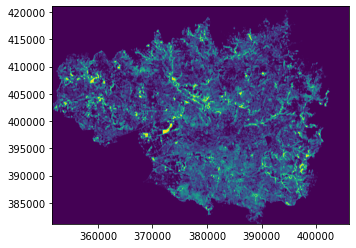

--- 1.3362250328063965 seconds ---


In [80]:
# Canopy% exposure map at 100 m
start_time = time.time()
canopy_src_100 = rasterio.open("thesis_project/output/layers/canopy_output_100.tif")
show(canopy_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [81]:
# output layer metadata
canopy_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 3.3.2. Canopy% map capturing exposure for a buffer zone of 300 m

In [82]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/layers/canopy_output_300.tif', 'w', driver='GTiff',
                            height = canopy_output_300.shape[0], width = canopy_output_300.shape[1],
                            count=1, dtype=str(canopy_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(canopy_output_300, 1)
new_dataset.close()

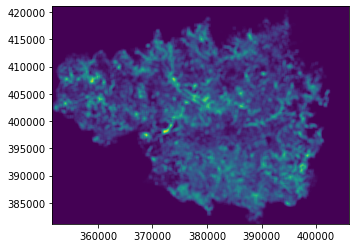

--- 1.463087797164917 seconds ---


In [83]:
# Canopy% exposure map at 300 m
start_time = time.time()
canopy_src_300 = rasterio.open("thesis_project/output/layers/canopy_output_300.tif")
show(canopy_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [84]:
# output layer metadata
canopy_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 3.3.3. Canopy% map capturing exposure for a buffer zone of 500 m

In [85]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/layers/canopy_output_500.tif', 'w', driver='GTiff',
                            height = canopy_output_500.shape[0], width = canopy_output_500.shape[1],
                            count=1, dtype=str(canopy_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(canopy_output_500, 1)
new_dataset.close()

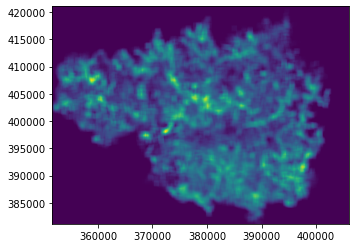

--- 1.5011341571807861 seconds ---


In [86]:
# Canopy% exposure map at 500 m
start_time = time.time()
canopy_src_500 = rasterio.open("thesis_project/output/layers/canopy_output_500.tif")
show(canopy_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [87]:
# output layer metadata
canopy_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

## 3.4. Step 5: extraction of raster values

In [88]:
# read Geopackage containing GM boundary
gm_boundaries = gpd.read_file("thesis_project/data/GM_Boundary.gpkg")
gm_boundaries.head()

,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,geometry
0,1,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,"MULTIPOLYGON (((406087.197 404640.102, 406041...."


<AxesSubplot:>

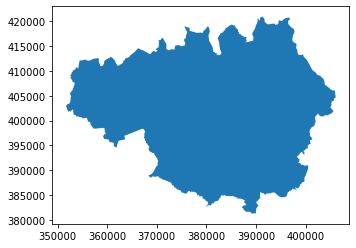

In [89]:
# plot GM boundary
gm_boundaries.plot()

### 3.4.1. Extraction of Canopy% values for a buffer zone of 100 m

In [90]:
# check gdf
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (386483.262 417703.544),"(386483.2622661036, 417703.5436785722)",0.455823,0.992861
1,POINT (395310.475 388609.235),"(395310.47527057823, 388609.2352984041)",0.387782,0.521713
2,POINT (384225.708 417867.819),"(384225.7075745344, 417867.8191836241)",0.389722,0.979774
3,POINT (390673.998 416261.747),"(390673.99783145625, 416261.7470128737)",0.623486,0.771565
4,POINT (393523.154 393041.484),"(393523.1537645239, 393041.4841191741)",0.628733,0.886972


In [91]:
# join greenspace metrics and GM boundaries
gdf_100_full = sjoin(gdf_100, gm_boundaries, how='left')

# take rows where 'index_right' is not NaN
gdf_100 = gdf_100_full[gdf_100_full['index_right'].notna()].reset_index(drop=True)
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2
0,POINT (386483.262 417703.544),"(386483.2622661036, 417703.5436785722)",0.455823,0.992861,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
1,POINT (395310.475 388609.235),"(395310.47527057823, 388609.2352984041)",0.387782,0.521713,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
2,POINT (384225.708 417867.819),"(384225.7075745344, 417867.8191836241)",0.389722,0.979774,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
3,POINT (390673.998 416261.747),"(390673.99783145625, 416261.7470128737)",0.623486,0.771565,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
4,POINT (393523.154 393041.484),"(393523.1537645239, 393041.4841191741)",0.628733,0.886972,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98


In [92]:
# check how many points within GM with all metrics
len(gdf_100)

5937

In [93]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Canopy%_100'] = [x[0] for x in canopy_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100
0,POINT (386483.262 417703.544),"(386483.2622661036, 417703.5436785722)",0.455823,0.992861,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.168372e-17
1,POINT (395310.475 388609.235),"(395310.47527057823, 388609.2352984041)",0.387782,0.521713,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.176871e-01
2,POINT (384225.708 417867.819),"(384225.7075745344, 417867.8191836241)",0.389722,0.979774,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,5.117090e-17
3,POINT (390673.998 416261.747),"(390673.99783145625, 416261.7470128737)",0.623486,0.771565,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,8.163265e-02
4,POINT (393523.154 393041.484),"(393523.1537645239, 393041.4841191741)",0.628733,0.886972,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,6.643991e-01


### 3.4.2. Extraction of Canopy% values for a buffer zone of 300 m

In [94]:
# check gdf
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (387760.076 393972.512),"(387760.0759851058, 393972.5115567864)",0.280478,0.326412
1,POINT (361558.182 408801.964),"(361558.18217695353, 408801.96443030925)",0.503846,0.847073
2,POINT (373792.953 382499.542),"(373792.9530222948, 382499.54218211595)",0.534135,0.999454
3,POINT (391126.815 417220.287),"(391126.8149730632, 417220.28661031264)",0.589265,0.831569
4,POINT (361327.964 411390.899),"(361327.9638465452, 411390.8985426932)",0.493672,0.796394


In [95]:
# join greenspace metrics and GM boundaries
gdf_300_full = sjoin(gdf_300, gm_boundaries, how='left')

# take rows where 'index_right' is not NaN
gdf_300 = gdf_300_full[gdf_300_full['index_right'].notna()].reset_index(drop=True)
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2
0,POINT (387760.076 393972.512),"(387760.0759851058, 393972.5115567864)",0.280478,0.326412,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
1,POINT (361558.182 408801.964),"(361558.18217695353, 408801.96443030925)",0.503846,0.847073,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
2,POINT (391126.815 417220.287),"(391126.8149730632, 417220.28661031264)",0.589265,0.831569,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
3,POINT (361327.964 411390.899),"(361327.9638465452, 411390.8985426932)",0.493672,0.796394,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
4,POINT (377099.280 400575.430),"(377099.28010794637, 400575.4299151844)",0.343043,0.610614,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98


In [96]:
# check how many points within GM with all metrics
len(gdf_300)

5820

In [97]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Canopy%_300'] = [x[0] for x in canopy_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300
0,POINT (387760.076 393972.512),"(387760.0759851058, 393972.5115567864)",0.280478,0.326412,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.145660
1,POINT (361558.182 408801.964),"(361558.18217695353, 408801.96443030925)",0.503846,0.847073,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.062886
2,POINT (391126.815 417220.287),"(391126.8149730632, 417220.28661031264)",0.589265,0.831569,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.104542
3,POINT (361327.964 411390.899),"(361327.9638465452, 411390.8985426932)",0.493672,0.796394,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.127654
4,POINT (377099.280 400575.430),"(377099.28010794637, 400575.4299151844)",0.343043,0.610614,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.275732


### 3.4.3. Extraction of Canopy% values for a buffer zone of 500 m

In [98]:
# check gdf
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (401901.359 408671.581),"(401901.3593869965, 408671.58071634814)",0.407077,0.982575
1,POINT (360687.924 381854.801),"(360687.9242329277, 381854.8006974825)",0.583116,0.985842
2,POINT (370492.613 385685.371),"(370492.6127017365, 385685.37054465216)",0.483239,0.994406
3,POINT (402055.383 382460.467),"(402055.3825253075, 382460.466940623)",0.638895,0.997822
4,POINT (368835.367 407479.786),"(368835.3672736198, 407479.7858508136)",0.441260,0.575357


In [99]:
# join greenspace metrics and GM boundaries
gdf_500_full = sjoin(gdf_500, gm_boundaries, how='left')

# take rows where 'index_right' is not NaN
gdf_500 = gdf_500_full[gdf_500_full['index_right'].notna()].reset_index(drop=True)
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2
0,POINT (401901.359 408671.581),"(401901.3593869965, 408671.58071634814)",0.407077,0.982575,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
1,POINT (368835.367 407479.786),"(368835.3672736198, 407479.7858508136)",0.441260,0.575357,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
2,POINT (377751.293 401260.842),"(377751.2932517506, 401260.8415491268)",0.312300,0.395262,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
3,POINT (391535.548 395524.756),"(391535.5477535281, 395524.7555887456)",0.283220,0.355313,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
4,POINT (369836.790 402258.456),"(369836.78979832743, 402258.45638805866)",0.552286,0.770303,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98


In [100]:
# check how many points within GM with all metrics
len(gdf_500)

2896

In [101]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Canopy%_500'] = [x[0] for x in canopy_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500
0,POINT (401901.359 408671.581),"(401901.3593869965, 408671.58071634814)",0.407077,0.982575,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.006176
1,POINT (368835.367 407479.786),"(368835.3672736198, 407479.7858508136)",0.441260,0.575357,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.167827
2,POINT (377751.293 401260.842),"(377751.2932517506, 401260.8415491268)",0.312300,0.395262,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.212136
3,POINT (391535.548 395524.756),"(391535.5477535281, 395524.7555887456)",0.283220,0.355313,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.098324
4,POINT (369836.790 402258.456),"(369836.78979832743, 402258.45638805866)",0.552286,0.770303,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.265954


# 4. Grass density

## 4.1. Step 1: processing Grass density input image

In [102]:
# data dir
data_dir = r"thesis_project/data"
fp_grass = os.path.join(data_dir, "Grass_no_grass_10m.TIF")

# open the file
grass_input_raster = rasterio.open(fp_grass)

# check type of the variable 'raster'
type(grass_input_raster)

rasterio.io.DatasetReader

In [103]:
# check metadata for the whole raster dataset
grass_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

In [104]:
# read the raster band as separate variable
grass_input = grass_input_raster.read(1)
#grass_input
type(grass_input)

numpy.ndarray

In [105]:
# convert array to uint8
grass_input = grass_input.astype(np.uint8)
grass_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

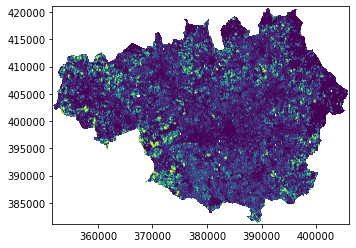

<AxesSubplot:>

In [106]:
# plot Grass density input image
show(grass_input_raster, 1)

## 4.2. Step 2: focal statistics analysis

### 4.2.1. Focal statistics analysis for a buffer zone of 100 meters

In [107]:
# design kernel for a buffer zone of 100 m (r = 21 for 10 x 10 m resolution)
grass_filter_100 = np.ones((21, 21))
grass_filter_100.shape

(21, 21)

In [108]:
# convolve filter (i.e. buffer zone) over the whole Grass density image using FFT and average Grass density values. 
# if mode = "same", the output size will equal the size of the input. Convolution assumes zero-padding boundaries.
start_time = time.time()
grass_output_100 = fftconvolve(grass_input, grass_filter_100, mode = "same") / np.sum(grass_filter_100) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
grass_output_100.shape

--- 2.315244197845459 seconds ---


(3987, 5441)

### 4.2.2. Focal statistics analysis for a buffer zone of 300 meters

In [109]:
# design kernel for a buffer zone of 300 m (r = 61 for 10 x 10 m resolution)
grass_filter_300 = np.ones((61, 61))
grass_filter_300.shape

(61, 61)

In [110]:
# convolve filter (i.e. buffer zone) over the whole Grass density image using FFT and average Grass density values. 
start_time = time.time()
grass_output_300 = fftconvolve(grass_input, grass_filter_300, mode = "same") / np.sum(grass_filter_300) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
grass_output_300.shape

--- 1.8092799186706543 seconds ---


(3987, 5441)

### 4.2.3. Focal statistics analysis for a buffer zone of 500 meters

In [111]:
# design kernel for a buffer zone of 500 m (r = 101 for 10 x 10 m resolution)
grass_filter_500 = np.ones((101, 101))
grass_filter_500.shape

(101, 101)

In [112]:
# convolve filter (i.e. buffer zone) over the whole Grass density image using FFT and average Grass density values.
start_time = time.time()
grass_output_500 = fftconvolve(grass_input, grass_filter_500, mode = "same") / np.sum(grass_filter_500) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
grass_output_500.shape

--- 1.8601441383361816 seconds ---


(3987, 5441)

## 4.3. Step 3: development of Grass% exposure maps

In [113]:
# checking bounds
grass_input_raster.bounds

BoundingBox(left=351662.35, bottom=381166.0433, right=406072.35, top=421036.0433)

### 4.3.1. Grass% map capturing exposure for a buffer zone of 100 m

In [114]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/grass_output_100.tif', 'w', driver='GTiff',
                            height = grass_output_100.shape[0], width = grass_output_100.shape[1],
                            count=1, dtype=str(grass_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(grass_output_100, 1)
new_dataset.close()

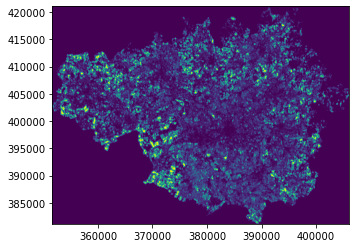

--- 1.319962978363037 seconds ---


In [115]:
# Grass% exposure map at 100 m
start_time = time.time()
grass_src_100 = rasterio.open("thesis_project/output/layers/grass_output_100.tif")
show(grass_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [116]:
# output layer metadata
grass_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 4.3.2. Grass% map capturing exposure for a buffer zone of 300 m

In [117]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/grass_output_300.tif', 'w', driver='GTiff',
                            height = grass_output_300.shape[0], width = grass_output_300.shape[1],
                            count=1, dtype=str(grass_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(grass_output_300, 1)
new_dataset.close()

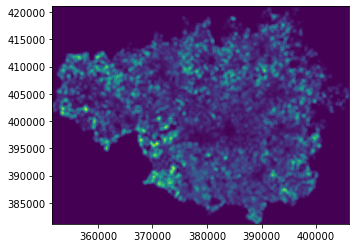

--- 1.8121798038482666 seconds ---


In [118]:
# Grass% exposure map at 300 m
start_time = time.time()
grass_src_300 = rasterio.open("thesis_project/output/layers/grass_output_300.tif")
show(grass_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [119]:
# output layer metadata
grass_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 4.3.3. Grass% map capturing exposure for a buffer zone of 500 m

In [120]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/grass_output_500.tif', 'w', driver='GTiff',
                            height = grass_output_500.shape[0], width = grass_output_500.shape[1],
                            count=1, dtype=str(grass_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(grass_output_500, 1)
new_dataset.close()

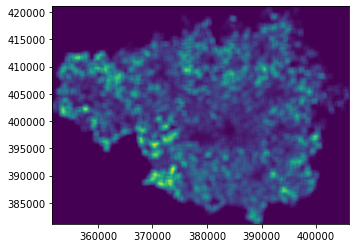

--- 1.8389639854431152 seconds ---


In [121]:
# Grass% exposure map at 500 m
start_time = time.time()
grass_src_500 = rasterio.open("thesis_project/output/layers/grass_output_500.tif")
show(grass_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [122]:
# output layer metadata
grass_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

## 4.4. Step 5: extraction of raster values

### 4.4.1. Extraction of Grass% values for a buffer zone of 100 m

In [123]:
# check greenspace metrics df
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100
0,POINT (386483.262 417703.544),"(386483.2622661036, 417703.5436785722)",0.455823,0.992861,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.168372e-17
1,POINT (395310.475 388609.235),"(395310.47527057823, 388609.2352984041)",0.387782,0.521713,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.176871e-01
2,POINT (384225.708 417867.819),"(384225.7075745344, 417867.8191836241)",0.389722,0.979774,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,5.117090e-17
3,POINT (390673.998 416261.747),"(390673.99783145625, 416261.7470128737)",0.623486,0.771565,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,8.163265e-02
4,POINT (393523.154 393041.484),"(393523.1537645239, 393041.4841191741)",0.628733,0.886972,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,6.643991e-01


In [124]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Grass%_100'] = [x[0] for x in grass_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100,Grass%_100
0,POINT (386483.262 417703.544),"(386483.2622661036, 417703.5436785722)",0.455823,0.992861,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.168372e-17,0.006803
1,POINT (395310.475 388609.235),"(395310.47527057823, 388609.2352984041)",0.387782,0.521713,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.176871e-01,0.097506
2,POINT (384225.708 417867.819),"(384225.7075745344, 417867.8191836241)",0.389722,0.979774,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,5.117090e-17,0.083900
3,POINT (390673.998 416261.747),"(390673.99783145625, 416261.7470128737)",0.623486,0.771565,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,8.163265e-02,0.083900
4,POINT (393523.154 393041.484),"(393523.1537645239, 393041.4841191741)",0.628733,0.886972,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,6.643991e-01,0.052154


### 4.4.2. Extraction of Grass% values for a buffer zone of 300 m

In [125]:
# check greenspace metrics df
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300
0,POINT (387760.076 393972.512),"(387760.0759851058, 393972.5115567864)",0.280478,0.326412,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.145660
1,POINT (361558.182 408801.964),"(361558.18217695353, 408801.96443030925)",0.503846,0.847073,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.062886
2,POINT (391126.815 417220.287),"(391126.8149730632, 417220.28661031264)",0.589265,0.831569,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.104542
3,POINT (361327.964 411390.899),"(361327.9638465452, 411390.8985426932)",0.493672,0.796394,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.127654
4,POINT (377099.280 400575.430),"(377099.28010794637, 400575.4299151844)",0.343043,0.610614,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.275732


In [126]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Grass%_300'] = [x[0] for x in grass_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300,Grass%_300
0,POINT (387760.076 393972.512),"(387760.0759851058, 393972.5115567864)",0.280478,0.326412,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.145660,0.080623
1,POINT (361558.182 408801.964),"(361558.18217695353, 408801.96443030925)",0.503846,0.847073,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.062886,0.391561
2,POINT (391126.815 417220.287),"(391126.8149730632, 417220.28661031264)",0.589265,0.831569,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.104542,0.243752
3,POINT (361327.964 411390.899),"(361327.9638465452, 411390.8985426932)",0.493672,0.796394,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.127654,0.150497
4,POINT (377099.280 400575.430),"(377099.28010794637, 400575.4299151844)",0.343043,0.610614,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.275732,0.147272


### 4.4.3. Extraction of Grass% values for a buffer zone of 500 m

In [127]:
# check greenspace metrics df
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500
0,POINT (401901.359 408671.581),"(401901.3593869965, 408671.58071634814)",0.407077,0.982575,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.006176
1,POINT (368835.367 407479.786),"(368835.3672736198, 407479.7858508136)",0.441260,0.575357,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.167827
2,POINT (377751.293 401260.842),"(377751.2932517506, 401260.8415491268)",0.312300,0.395262,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.212136
3,POINT (391535.548 395524.756),"(391535.5477535281, 395524.7555887456)",0.283220,0.355313,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.098324
4,POINT (369836.790 402258.456),"(369836.78979832743, 402258.45638805866)",0.552286,0.770303,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.265954


In [128]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Grass%_500'] = [x[0] for x in grass_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500,Grass%_500
0,POINT (401901.359 408671.581),"(401901.3593869965, 408671.58071634814)",0.407077,0.982575,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.006176,0.028919
1,POINT (368835.367 407479.786),"(368835.3672736198, 407479.7858508136)",0.441260,0.575357,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.167827,0.131850
2,POINT (377751.293 401260.842),"(377751.2932517506, 401260.8415491268)",0.312300,0.395262,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.212136,0.095873
3,POINT (391535.548 395524.756),"(391535.5477535281, 395524.7555887456)",0.283220,0.355313,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.098324,0.070777
4,POINT (369836.790 402258.456),"(369836.78979832743, 402258.45638805866)",0.552286,0.770303,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.265954,0.094795


# 5. Forbs and shrubs density

## 5.1. Step 1: processing forbs and shurbs density input image

In [129]:
# data dir
data_dir = r"thesis_project/data"
fp_shrubs = os.path.join(data_dir, "Shrubs_no_shrubs_10m.TIF")

# open the file
shrubs_input_raster = rasterio.open(fp_shrubs)

# check type of the variable 'raster'
type(shrubs_input_raster)

rasterio.io.DatasetReader

In [130]:
# check metadata for the whole raster dataset
shrubs_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

In [131]:
# read the raster band as separate variable
shrubs_input = shrubs_input_raster.read(1)
#shrubs_input
type(shrubs_input)

numpy.ndarray

In [132]:
# convert array to uint8
shrubs_input = shrubs_input.astype(np.uint8)
shrubs_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

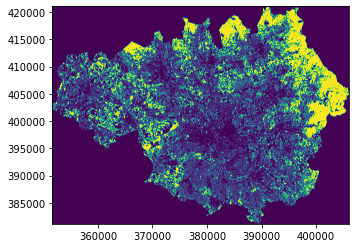

<AxesSubplot:>

In [133]:
# plot input map
show(shrubs_input_raster, 1)

## 5.2. Step 2: focal statistics analysis

### 5.2.1. Focal statistics analysis for a buffer zone of 100 meters

In [134]:
# design kernel for a buffer zone of 100 m (r = 21 for 10 x 10 m resolution)
shrubs_filter_100 = np.ones((21, 21))
shrubs_filter_100.shape

(21, 21)

In [135]:
# convolve filter (i.e. buffer zone) over the whole shrubs density image using FFT and average shrubs density values. 
# if mode = "same", the output size will equal the size of the input. Convolution assumes zero-padding boundaries.
start_time = time.time()
shrubs_output_100 = fftconvolve(shrubs_input, shrubs_filter_100, mode = "same") / np.sum(shrubs_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
shrubs_output_100.shape

--- 2.473466157913208 seconds ---


(3987, 5441)

### 5.2.2. Focal statistics analysis for a buffer zone of 300 meters

In [136]:
# design kernel for a buffer zone of 300 m (r = 61 for 10 x 10 m resolution)
shrubs_filter_300 = np.ones((61, 61))
shrubs_filter_300.shape

(61, 61)

In [137]:
# convolve filter (i.e. buffer zone) over the whole shrubs density image using FFT and average shrubs density values.
start_time = time.time()
shrubs_output_300 = fftconvolve(shrubs_input, shrubs_filter_300, mode = "same") / np.sum(shrubs_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
shrubs_output_300.shape

--- 1.7767558097839355 seconds ---


(3987, 5441)

### 5.2.3. Focal statistics analysis for a buffer zone of 500 meters

In [138]:
# design kernel for a buffer zone of 500 m (r = 101 for 10 x 10 m resolution)
shrubs_filter_500 = np.ones((101, 101))
shrubs_filter_500.shape

(101, 101)

In [139]:
# convolve filter (i.e. buffer zone) over the whole shrubs density image using FFT and average shrubs density values.
start_time = time.time()
shrubs_output_500 = fftconvolve(shrubs_input, shrubs_filter_500, mode = "same") / np.sum(shrubs_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
shrubs_output_500.shape

--- 1.7161328792572021 seconds ---


(3987, 5441)

## 5.3. Step 3: development of Shrubs% exposure maps

In [140]:
# checking bounds
shrubs_input_raster.bounds

BoundingBox(left=351662.35, bottom=381166.0433, right=406072.35, top=421036.0433)

### 5.3.1. Shrubs% map capturing exposure for a buffer zone of 100 m

In [141]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/shrubs_output_100.tif', 'w', driver='GTiff',
                            height = shrubs_output_100.shape[0], width = shrubs_output_100.shape[1],
                            count=1, dtype=str(shrubs_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(shrubs_output_100, 1)
new_dataset.close()

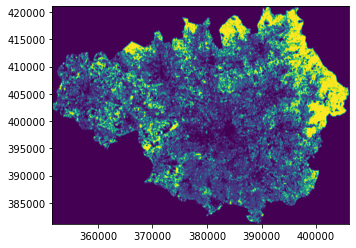

--- 1.3376200199127197 seconds ---


In [142]:
# Shrubs% exposure map at 100 m
start_time = time.time()
shrubs_src_100 = rasterio.open("thesis_project/output/layers/shrubs_output_100.tif")
show(shrubs_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [143]:
# output layer metadata
shrubs_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 5.3.2. Shrubs% map capturing exposure for a buffer zone of 300 m

In [144]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/shrubs_output_300.tif', 'w', driver='GTiff',
                            height = shrubs_output_300.shape[0], width = shrubs_output_300.shape[1],
                            count=1, dtype=str(shrubs_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(shrubs_output_300, 1)
new_dataset.close()

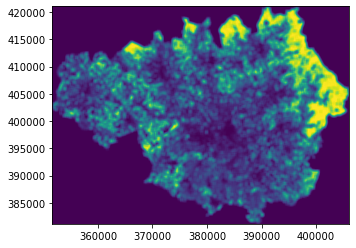

--- 1.5554659366607666 seconds ---


In [145]:
# Shrubs% exposure map at 300 m
start_time = time.time()
shrubs_src_300 = rasterio.open("thesis_project/output/layers/shrubs_output_300.tif")
show(shrubs_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [146]:
# output layer metadata
shrubs_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 5.3.3. Shrubs% map capturing exposure for a buffer zone of 500 m

In [147]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/shrubs_output_500.tif', 'w', driver='GTiff',
                            height = shrubs_output_500.shape[0], width = shrubs_output_500.shape[1],
                            count=1, dtype=str(shrubs_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(shrubs_output_500, 1)
new_dataset.close()

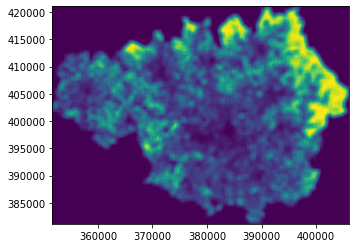

--- 2.1796231269836426 seconds ---


In [148]:
# Shrubs% exposure map at 500 m
start_time = time.time()
shrubs_src_500 = rasterio.open("thesis_project/output/layers/shrubs_output_500.tif")
show(shrubs_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [149]:
# output layer metadata
shrubs_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

## 5.4. Step 5: extraction of raster values

### 5.4.1. Extraction of Shrubs% values for a buffer zone of 100 m

In [150]:
# check greenspace metrics df
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100,Grass%_100
0,POINT (386483.262 417703.544),"(386483.2622661036, 417703.5436785722)",0.455823,0.992861,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.168372e-17,0.006803
1,POINT (395310.475 388609.235),"(395310.47527057823, 388609.2352984041)",0.387782,0.521713,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.176871e-01,0.097506
2,POINT (384225.708 417867.819),"(384225.7075745344, 417867.8191836241)",0.389722,0.979774,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,5.117090e-17,0.083900
3,POINT (390673.998 416261.747),"(390673.99783145625, 416261.7470128737)",0.623486,0.771565,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,8.163265e-02,0.083900
4,POINT (393523.154 393041.484),"(393523.1537645239, 393041.4841191741)",0.628733,0.886972,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,6.643991e-01,0.052154


In [151]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Shrubs%_100'] = [x[0] for x in shrubs_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100,Grass%_100,Shrubs%_100
0,POINT (386483.262 417703.544),"(386483.2622661036, 417703.5436785722)",0.455823,0.992861,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.168372e-17,0.006803,0.848073
1,POINT (395310.475 388609.235),"(395310.47527057823, 388609.2352984041)",0.387782,0.521713,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.176871e-01,0.097506,0.190476
2,POINT (384225.708 417867.819),"(384225.7075745344, 417867.8191836241)",0.389722,0.979774,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,5.117090e-17,0.083900,0.891156
3,POINT (390673.998 416261.747),"(390673.99783145625, 416261.7470128737)",0.623486,0.771565,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,8.163265e-02,0.083900,0.612245
4,POINT (393523.154 393041.484),"(393523.1537645239, 393041.4841191741)",0.628733,0.886972,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,6.643991e-01,0.052154,0.163265


In [152]:
# check how many points within GM with all metrics
len(gdf_100)

5937

In [153]:
# keep target columns
gdf_100 = gdf_100[['NDVI_100', 'Greenspace%_100', 'Canopy%_100', 'Grass%_100', 'Shrubs%_100', 'geometry']]

# normalize continuous variables (min-max)
# cols_to_norm = ['NDVI_100','Greenspace%_100', 'Canopy%_100', 'Grass%_100', 'Shrubs%_100']
# gdf_100[cols_to_norm] = gdf_100[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_100.head()

,NDVI_100,Greenspace%_100,Canopy%_100,Grass%_100,Shrubs%_100,geometry
0,0.455823,0.992861,2.168372e-17,0.006803,0.848073,POINT (386483.262 417703.544)
1,0.387782,0.521713,2.176871e-01,0.097506,0.190476,POINT (395310.475 388609.235)
2,0.389722,0.979774,5.117090e-17,0.083900,0.891156,POINT (384225.708 417867.819)
3,0.623486,0.771565,8.163265e-02,0.083900,0.612245,POINT (390673.998 416261.747)
4,0.628733,0.886972,6.643991e-01,0.052154,0.163265,POINT (393523.154 393041.484)


In [154]:
# save geodataframe to geojson
gdf_100.to_file("thesis_project/output/dataframes/greenspace_metrics_100_df_2.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 5.4.2. Extraction of Shrubs% values for a buffer zone of 300 m

In [155]:
# check greenspace metrics df
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300,Grass%_300
0,POINT (387760.076 393972.512),"(387760.0759851058, 393972.5115567864)",0.280478,0.326412,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.145660,0.080623
1,POINT (361558.182 408801.964),"(361558.18217695353, 408801.96443030925)",0.503846,0.847073,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.062886,0.391561
2,POINT (391126.815 417220.287),"(391126.8149730632, 417220.28661031264)",0.589265,0.831569,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.104542,0.243752
3,POINT (361327.964 411390.899),"(361327.9638465452, 411390.8985426932)",0.493672,0.796394,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.127654,0.150497
4,POINT (377099.280 400575.430),"(377099.28010794637, 400575.4299151844)",0.343043,0.610614,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.275732,0.147272


In [156]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Shrubs%_300'] = [x[0] for x in shrubs_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300,Grass%_300,Shrubs%_300
0,POINT (387760.076 393972.512),"(387760.0759851058, 393972.5115567864)",0.280478,0.326412,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.145660,0.080623,0.097554
1,POINT (361558.182 408801.964),"(361558.18217695353, 408801.96443030925)",0.503846,0.847073,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.062886,0.391561,0.387530
2,POINT (391126.815 417220.287),"(391126.8149730632, 417220.28661031264)",0.589265,0.831569,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.104542,0.243752,0.480785
3,POINT (361327.964 411390.899),"(361327.9638465452, 411390.8985426932)",0.493672,0.796394,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.127654,0.150497,0.513034
4,POINT (377099.280 400575.430),"(377099.28010794637, 400575.4299151844)",0.343043,0.610614,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.275732,0.147272,0.190540


In [157]:
# check how many points within GM with all metrics
len(gdf_300)

5820

In [158]:
# keep target columns
gdf_300 = gdf_300[['NDVI_300', 'Greenspace%_300', 'Canopy%_300', 'Grass%_300', 'Shrubs%_300', 'geometry']]

# normalize continuous variables (min-max)
# cols_to_norm = ['NDVI_300', 'Greenspace%_300', 'Canopy%_300', 'Grass%_300', 'Shrubs%_300']
# gdf_300[cols_to_norm] = gdf_300[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_300.head()

,NDVI_300,Greenspace%_300,Canopy%_300,Grass%_300,Shrubs%_300,geometry
0,0.280478,0.326412,0.145660,0.080623,0.097554,POINT (387760.076 393972.512)
1,0.503846,0.847073,0.062886,0.391561,0.387530,POINT (361558.182 408801.964)
2,0.589265,0.831569,0.104542,0.243752,0.480785,POINT (391126.815 417220.287)
3,0.493672,0.796394,0.127654,0.150497,0.513034,POINT (361327.964 411390.899)
4,0.343043,0.610614,0.275732,0.147272,0.190540,POINT (377099.280 400575.430)


In [159]:
# save geodataframe to geojson
gdf_300.to_file("thesis_project/output/dataframes/greenspace_metrics_300_df_2.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 5.4.3. Extraction of Shrubs% values for a buffer zone of 500 m

In [160]:
# check greenspace metrics df
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500,Grass%_500
0,POINT (401901.359 408671.581),"(401901.3593869965, 408671.58071634814)",0.407077,0.982575,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.006176,0.028919
1,POINT (368835.367 407479.786),"(368835.3672736198, 407479.7858508136)",0.441260,0.575357,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.167827,0.131850
2,POINT (377751.293 401260.842),"(377751.2932517506, 401260.8415491268)",0.312300,0.395262,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.212136,0.095873
3,POINT (391535.548 395524.756),"(391535.5477535281, 395524.7555887456)",0.283220,0.355313,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.098324,0.070777
4,POINT (369836.790 402258.456),"(369836.78979832743, 402258.45638805866)",0.552286,0.770303,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.265954,0.094795


In [161]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Shrubs%_500'] = [x[0] for x in shrubs_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500,Grass%_500,Shrubs%_500
0,POINT (401901.359 408671.581),"(401901.3593869965, 408671.58071634814)",0.407077,0.982575,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.006176,0.028919,0.947064
1,POINT (368835.367 407479.786),"(368835.3672736198, 407479.7858508136)",0.441260,0.575357,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.167827,0.131850,0.277816
2,POINT (377751.293 401260.842),"(377751.2932517506, 401260.8415491268)",0.312300,0.395262,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.212136,0.095873,0.087050
3,POINT (391535.548 395524.756),"(391535.5477535281, 395524.7555887456)",0.283220,0.355313,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.098324,0.070777,0.188119
4,POINT (369836.790 402258.456),"(369836.78979832743, 402258.45638805866)",0.552286,0.770303,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.265954,0.094795,0.409666


In [162]:
# check how many points within GM with all metrics
len(gdf_500)

2896

In [163]:
# keep target columns
gdf_500 = gdf_500[['NDVI_500', 'Greenspace%_500', 'Canopy%_500', 'Grass%_500', 'Shrubs%_500', 'geometry']]

# normalize continuous variables (min-max)
# cols_to_norm = ['NDVI_500', 'Greenspace%_500', 'Canopy%_500', 'Grass%_500', 'Shrubs%_500']
# gdf_500[cols_to_norm] = gdf_500[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_500.head()

,NDVI_500,Greenspace%_500,Canopy%_500,Grass%_500,Shrubs%_500,geometry
0,0.407077,0.982575,0.006176,0.028919,0.947064,POINT (401901.359 408671.581)
1,0.441260,0.575357,0.167827,0.131850,0.277816,POINT (368835.367 407479.786)
2,0.312300,0.395262,0.212136,0.095873,0.087050,POINT (377751.293 401260.842)
3,0.283220,0.355313,0.098324,0.070777,0.188119,POINT (391535.548 395524.756)
4,0.552286,0.770303,0.265954,0.094795,0.409666,POINT (369836.790 402258.456)


In [164]:
# save geodataframe to geojson
gdf_500.to_file("thesis_project/output/dataframes/greenspace_metrics_500_df_2.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
